In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
# MNIST Data Pre-processing
import numpy as np
import keras
import tensorflow as tf
from keras.datasets import mnist
from keras.utils import np_utils  # utilities for one-hot encoding of ground truth values

import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

target = 0
x_clean = np.load('../AdvGAN/samples/WB-B-t%d-clean.npy' % target)
x_adv = np.load('../AdvGAN/samples/WB-B-t%d-adv.npy' % target)
x_label = np.load('../AdvGAN/samples/WB-B-t%d-label.npy' % target)

%load_ext autoreload
%autoreload 2

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
from APEGAN import APEGAN

GAN, G, D = APEGAN([28,28,1])

epochs=200
batch_size=256

N = x_clean.shape[0]
scalarloss = [0,0,0]
for cur_epoch in range(epochs):
    idx = np.random.randint(0, N, size=batch_size)
    x_clean_batch = x_clean[idx,]
    x_adv_batch = x_adv[idx,]
    scalarloss[0] = D.train_on_batch(x_clean_batch, np.ones(batch_size))/2
    scalarloss[0] += D.train_on_batch(x_adv_batch, np.zeros(batch_size))/2
    GAN.train_on_batch(x_adv_batch, [np.ones(batch_size), x_clean_batch])
    scalarloss[1:] = GAN.train_on_batch(x_adv_batch, [np.ones(batch_size), x_clean_batch])[1:]
    print("Epoch number:",cur_epoch,"; Loss",scalarloss)

/usr/local/lib/python3.5/dist-packages/keras/engine/training.py:975: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch number: 0 ; Loss [4.6970352828502655, 0.028132845, 0.2828901]
Epoch number: 1 ; Loss [0.12297499924898148, 0.063889794, 0.23239896]
Epoch number: 2 ; Loss [0.18301286932546645, 0.17302912, 0.18988416]
Epoch number: 3 ; Loss [0.4591394792078063, 0.0962659, 0.1635281]
Epoch number: 4 ; Loss [0.1568309161812067, 0.05883308, 0.14375626]
Epoch number: 5 ; Loss [0.05387847125530243, 0.021403784, 0.12865838]
Epoch number: 6 ; Loss [0.10374701581895351, 0.017242268, 0.11874392]
Epoch number: 7 ; Loss [0.10528480168431997, 0.019653162, 0.11357207]
Epoch number: 8 ; Loss [0.07300085015594959, 0.04580777, 0.10749561]
Epoch number: 9 ; Loss [0.029817523434758186, 0.04569111, 0.1028259]
Epoch number: 10 ; Loss [0.018975975457578897, 0.038328037, 0.09992707]
Epoch number: 11 ; Loss [0.03231439832597971, 0.053197663, 0.09572759]
Epoch number: 12 ; Loss [0.03327732451725751, 0.03575253, 0.09375656]
Epoch number: 13 ; Loss [0.0226708697155118, 0.03576326, 0.09050974]
Epoch number: 14 ; Loss [0.02

Epoch number: 112 ; Loss [0.0004085158943780698, 0.0033539562, 0.04181934]
Epoch number: 113 ; Loss [0.0003805891319643706, 0.00082160113, 0.03924211]
Epoch number: 114 ; Loss [0.00045769361895509064, 0.0013184622, 0.039607976]
Epoch number: 115 ; Loss [0.0006292856851359829, 0.0031171045, 0.04074677]
Epoch number: 116 ; Loss [0.0004904996749246493, 0.0013751052, 0.040467937]
Epoch number: 117 ; Loss [0.0006299873493844643, 0.0024645636, 0.04060664]
Epoch number: 118 ; Loss [0.00028689617465715855, 0.00069368305, 0.040446796]
Epoch number: 119 ; Loss [0.0005497170350281522, 0.0042590527, 0.039492235]
Epoch number: 120 ; Loss [0.0005056030495325103, 0.0013784232, 0.039807074]
Epoch number: 121 ; Loss [0.0006413153314497322, 0.0027096372, 0.039964207]
Epoch number: 122 ; Loss [0.00040048101800493896, 0.0009260489, 0.03819185]
Epoch number: 123 ; Loss [0.0004518925561569631, 0.0011277187, 0.038243752]
Epoch number: 124 ; Loss [0.00046623506932519376, 0.0013528827, 0.03931909]
Epoch number

adv acc:0.0000, rct acc:0.9789
0


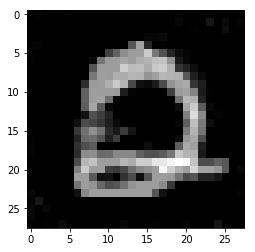

2


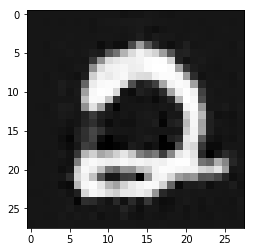

0


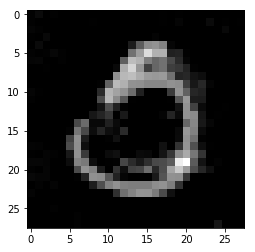

5


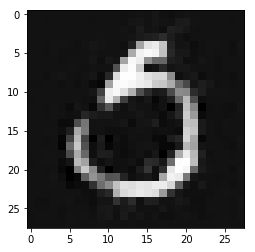

0


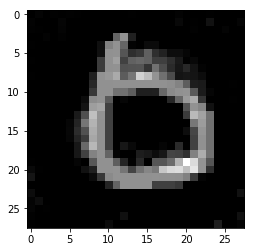

6


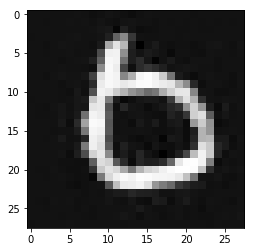

0


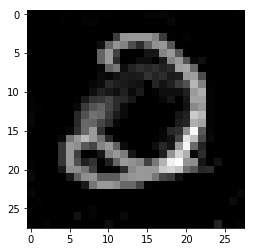

0


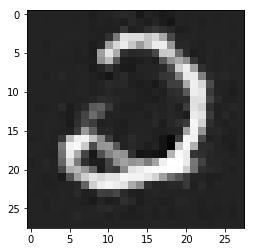

0


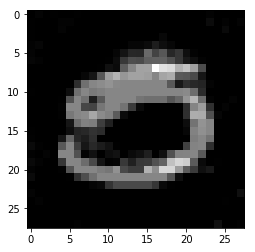

5


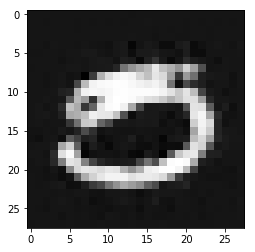

In [8]:
import matplotlib.pyplot as plt
import pickle

F = keras.models.load_model('../AdvGAN/models/Classifier-' + 'B' + '.h5')

test_range = x_adv.shape[0]//10
adv = x_adv[:test_range]
label = x_label[:test_range]
purified = G.predict(adv)
adv_pdt = np.argmax(F.predict(adv), axis=1)
purified_pdt = np.argmax(F.predict(purified), axis=1)

print('adv acc:{:.4f}, rct acc:{:.4f}'.format(np.sum(adv_pdt==label)/test_range, 
                                              np.sum(purified_pdt==label)/test_range))

for k in range(5):
    print(adv_pdt[k])
    plt.imshow((adv[k,] * 255).astype(np.int).reshape(28,28), cmap='gray')
    plt.show()
    print(purified_pdt[k])
    plt.imshow((purified[k,] * 255).astype(np.int).reshape(28,28), cmap='gray')
    plt.show()